In [1]:
import numpy as np
import copy
import torch 
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os
import wandb 
from copy import deepcopy
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image

# Dataset Classes

Here we show what transformations are applied to the datasets and how we preprocess labels. Since we are dealing with generative models, we steer clear from applying any image-altering transformations like jittering.

<u>**AFHQ:**</u> <br/>
<br/>
For the Animal Faces (AFHQ) dataset, we simply associate each class with a number. As we are dealing with centered faces, we avoid applying large rotational transformations. More precisely, the original 512x512px image is first resized to an intermediate size of 137x137px. Here, we can apply small random rotations between 0 and 4.2 degrees. Exceeding 4.2 degrees would create black borders in the image. One could choose a larger intermediate size to allow for higher rotations, but then certain features like the animals' ears would get cut off. We found our approach best, as it still contains all face features. After applying the rotations, we perform a center crop to achieve the final 128x128px image.

In [2]:
class ConditionalDataset_AFHQ_Class(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string):   Path to the folder where images are stored
            img_size (int):   Size of output image img_size=height=width
            ext (string):     Type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            train (Bool):     Choose dataset to be either train set or test set. frac(float) required 
        """        
        if train:
            fpath = os.path.join(fpath, 'train') 
        else:
            fpath = os.path.join(fpath, 'valid')
        
        self.class_to_idx = {'cat': 0, 'dog': 1, 'wild': 2}        

        file_list =[]
        class_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                if name.endswith(ext):
                    file_list.append(os.path.join(root, name))
                    class_list.append(self.class_to_idx[os.path.basename(root)])
        self.df = pd.DataFrame({"Filepath": file_list})
        self.class_list = class_list     
        
        if transform: 
            intermediate_size = 137
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*img_size))
            
            transform_rotate_flip =  transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(intermediate_size,antialias=True),
                                     transforms.RandomRotation((theta/np.pi*180),interpolation=transforms.InterpolationMode.BILINEAR),
                                     transforms.CenterCrop(img_size),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
            
            transform_flip =  transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(img_size, antialias=True),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            self.transform =  transforms.RandomChoice([transform_rotate_flip,transform_flip])                                                   
        else :
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])

 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        class_idx = self.class_list[idx]
        return self.transform(img), class_idx
        
    def tensor2PIL(self,img):
        back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
        return back2pil(img)

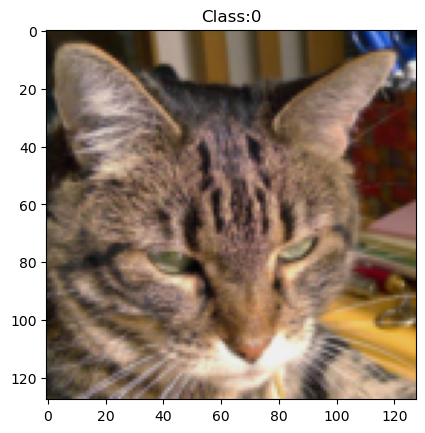

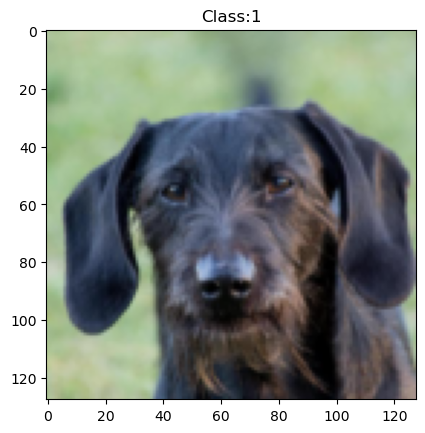

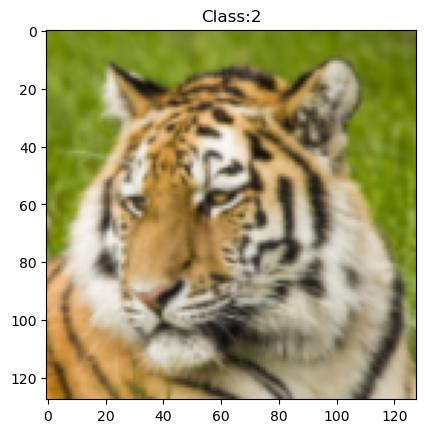

In [14]:
fpath = "/Users/gonzalo/Desktop/afhq_512/"
batch_size = 3
animal_ds = ConditionalDataset_AFHQ_Class(fpath=fpath,img_size=128,frac =0.8,skip_first_n = 0,ext = ".jpg",
                                      transform=True, train = True)
animal_loader = torch.utils.data.DataLoader(animal_ds,batch_size=batch_size, shuffle=True)
for idx, (x_0, y) in enumerate(animal_loader):
    for i in range(x_0.shape[0]):
        x_0_pil = animal_ds.tensor2PIL(x_0[i])
        fig, ax = plt.subplots()
        ax.imshow(x_0_pil)
        ax.set_title('Class:'+str(y[i].item()))
        plt.show()
    break

<u>**LHQ:**</u> <br/>
<br/>
For the inpainting model trained on the landscape dataset (LHQ), we apply the same transformations as used for the unconditional diffusion model on LHQ, see `dataloading.ipynb` in the `Unconditional_Diffusion_Model` folder. Here, we allow for greater rotations (between 0 and 10 degrees), while also applying random cropping instead of center cropping. The difference here lies in the computation of the label. In the `getitem` function, we copy the input image and randomly draw a black rectangle of height and width between 30px and 128px.

In [15]:
class ConditionalDataset_LHQ_Paint(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string):   Path to the folder where images are stored
            img_size (int):   Size of output image img_size=height=width
            ext (string):     Type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            train (Bool):     Choose dataset to be either train set or test set. frac(float) required 
            frac (float):     value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
        """        
     
        ### Create DataFrame
        file_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))

        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)] 
        
        
        if train: 
            df_train = self.df.sample(frac=frac,random_state=2)
            self.df = df_train
        else:
            df_train = self.df.sample(frac=frac,random_state=2)
            df_test = df.drop(df_train.index)
            self.df = df_test

        if transform: 
            intermediate_size = 150
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*img_size))
            
            transform_rotate =  transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize(intermediate_size,antialias=True),
                                                    transforms.RandomRotation(theta/np.pi*180,interpolation=transforms.InterpolationMode.BILINEAR),
                                                    transforms.CenterCrop(img_size),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
            
            transform_randomcrop  =  transforms.Compose([transforms.ToTensor(),
                                                         transforms.Resize(intermediate_size),
                                                         transforms.RandomCrop(img_size),
                                                         transforms.RandomHorizontalFlip(p=0.5), 
                                                         transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            self.transform =  transforms.RandomChoice([transform_rotate,transform_randomcrop])                                                  
        else :
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])

 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        # get image
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        # apply transformation
        img_tensor = self.transform(img)
        # draw random rectangle
        min_height = 30
        min_width = 30
        max_x = img_tensor.shape[1] - min_height
        max_y = img_tensor.shape[2] - min_width
        x = np.random.randint(0, max_x)  
        y = np.random.randint(0, max_y)
        max_height = min(128, img_tensor.shape[1] - x)
        max_width  = min(128, img_tensor.shape[2] - y) 
        rect_height = torch.randint(min_height, max_height, (1,)).item()
        rect_width  = torch.randint(min_width, max_width, (1,)).item() 
        # create copy of image and add blacked out rectangle
        masked_img = img_tensor.clone()
        masked_img[:, x:x+rect_height, y:y+rect_width] = -1 
        return img_tensor, masked_img
        
    def tensor2PIL(self,img):
        back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
        return back2pil(img)

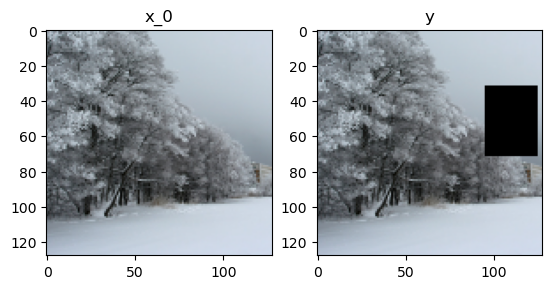

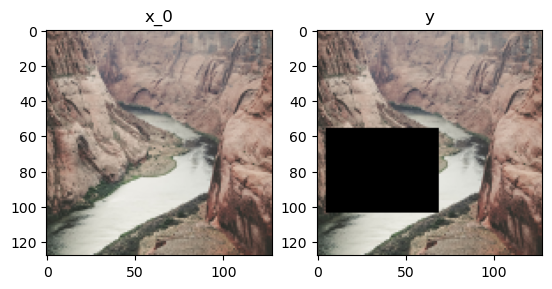

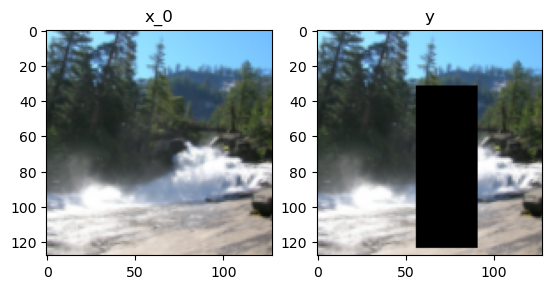

In [19]:
fpath = "/Users/gonzalo/Desktop/lhq_256/"
batch_size = 3
land_ds = ConditionalDataset_LHQ_Paint(fpath=fpath,img_size=128,frac =0.8,skip_first_n = 0,ext = ".png",
                                      transform=True, train = True)
land_loader = torch.utils.data.DataLoader(land_ds,batch_size=batch_size, shuffle=True)

for idx, (x_0, y) in enumerate(land_loader):
    for i in range(x_0.shape[0]):
        x_0_pil = land_ds.tensor2PIL(x_0[i])
        y_pil = land_ds.tensor2PIL(y[i])
        fig, ax = plt.subplots(1, 2)  
        ax[0].imshow(x_0_pil)  
        ax[0].set_title('x_0')  
        ax[1].imshow(y_pil)  
        ax[1].set_title('y') 
        plt.show()
    break

**To test the limits of our inpainting model, we try out different ways to mask the input image, as shown next.**

### Joining Two Landscapes

In [20]:
class ConditionalDataset_LHQ_Paint(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string):   Path to the folder where images are stored
            img_size (int):   Size of output image img_size=height=width
            ext (string):     Type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            train (Bool):     Choose dataset to be either train set or test set. frac(float) required 
            frac (float):     value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
        """        
        self.img_size = img_size
        ### Create DataFrame
        file_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))

        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)] 
        
        
        if train: 
            df_train = self.df.sample(frac=frac,random_state=2)
            self.df = df_train
        else:
            df_train = self.df.sample(frac=frac,random_state=2)
            df_test = df.drop(df_train.index)
            self.df = df_test

        if transform: 
            intermediate_size = 150
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*img_size))
            
            transform_rotate =  transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize(intermediate_size,antialias=True),
                                                    transforms.RandomRotation(theta/np.pi*180,interpolation=transforms.InterpolationMode.BILINEAR),
                                                    transforms.CenterCrop(img_size),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
            
            transform_randomcrop  =  transforms.Compose([transforms.ToTensor(),
                                                         transforms.Resize(intermediate_size),
                                                         transforms.RandomCrop(img_size),
                                                         transforms.RandomHorizontalFlip(p=0.5), 
                                                         transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            self.transform =  transforms.RandomChoice([transform_rotate,transform_randomcrop])                                                  
        else :
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize(img_size)])

 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        path_1 =  self.df.iloc[idx].Filepath
        path_2 =  self.df.iloc[(idx+1) % len(self.df)].Filepath
        img_1 = Image.open(path_1)
        img_2 = Image.open(path_2)
        # apply transformation
        img_tensor_1 = self.transform(img_1)
        img_tensor_2 = self.transform(img_2)
        # join two images
        center = 30
        sides = (self.img_size - center)//2
        left = img_tensor_1[:, :, -sides:]
        right = img_tensor_2[:, :, :sides]
        middle_strip = torch.full((3, self.img_size, center), -1)
        combined_img = torch.cat((left, middle_strip, right), dim=2)
        return img_tensor_1, img_tensor_2, combined_img
        
    def tensor2PIL(self,img):
        back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
        return back2pil(img)

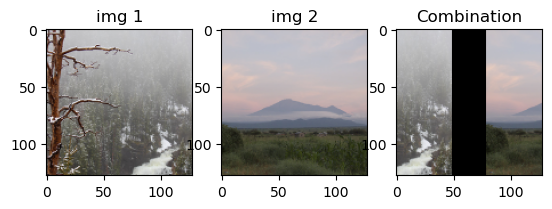

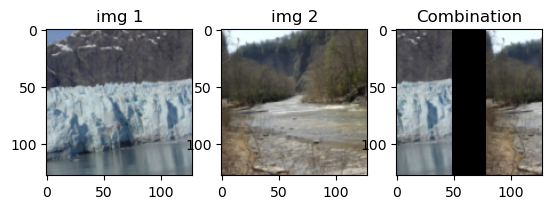

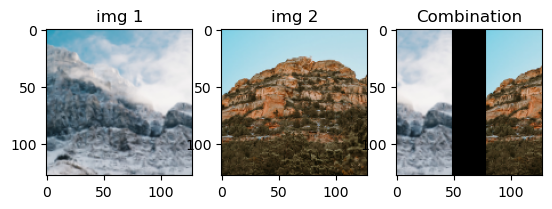

In [23]:
fpath = "/Users/gonzalo/Desktop/lhq_256/"
batch_size = 3
land_ds = ConditionalDataset_LHQ_Paint(fpath=fpath,img_size=128,frac =0.8,skip_first_n = 0,ext = ".png",
                                      transform=True, train = True)
land_loader = torch.utils.data.DataLoader(land_ds,batch_size=batch_size, shuffle=True)

for idx, (x_0, x_1, y) in enumerate(land_loader):
    for i in range(x_0.shape[0]):
        x_0_pil = land_ds.tensor2PIL(x_0[i])
        x_1_pil = land_ds.tensor2PIL(x_1[i])
        y_pil = land_ds.tensor2PIL(y[i])
        fig, ax = plt.subplots(1, 3)  
        ax[0].imshow(x_0_pil)  
        ax[0].set_title('img 1')
        ax[1].imshow(x_1_pil)  
        ax[1].set_title('img 2')
        ax[2].imshow(y_pil)  
        ax[2].set_title('Combination') 
        plt.show()
    break

### Two Masks

In [24]:
class ConditionalDataset_LHQ_Paint(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string):   Path to the folder where images are stored
            img_size (int):   Size of output image img_size=height=width
            ext (string):     Type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            train (Bool):     Choose dataset to be either train set or test set. frac(float) required 
            frac (float):     value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
        """        
        self.img_size = img_size
        ### Create DataFrame
        file_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))

        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)] 
        
        
        if train: 
            df_train = self.df.sample(frac=frac,random_state=2)
            self.df = df_train
        else:
            df_train = self.df.sample(frac=frac,random_state=2)
            df_test = df.drop(df_train.index)
            self.df = df_test

        if transform: 
            intermediate_size = 150
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*img_size))
            
            transform_rotate =  transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize(intermediate_size,antialias=True),
                                                    transforms.RandomRotation(theta/np.pi*180,interpolation=transforms.InterpolationMode.BILINEAR),
                                                    transforms.CenterCrop(img_size),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
            
            transform_randomcrop  =  transforms.Compose([transforms.ToTensor(),
                                                         transforms.Resize(intermediate_size),
                                                         transforms.RandomCrop(img_size),
                                                         transforms.RandomHorizontalFlip(p=0.5), 
                                                         transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            self.transform =  transforms.RandomChoice([transform_rotate,transform_randomcrop])                                                  
        else :
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])

 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        # get image
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        # apply transformation
        img_tensor = self.transform(img)
        masked_img = img_tensor.clone()
        for i in range(2):
            # draw random rectangle
            min_height = 30
            min_width = 30
            max_x = img_tensor.shape[1] - min_height
            max_y = img_tensor.shape[2] - min_width
            x = np.random.randint(0, max_x)  
            y = np.random.randint(0, max_y)
            max_height = min(self.img_size, img_tensor.shape[1] - x)
            max_width  = min(self.img_size, img_tensor.shape[2] - y) 
            rect_height = torch.randint(min_height, max_height, (1,)).item()
            rect_width  = torch.randint(min_width, max_width, (1,)).item() 
            masked_img[:, x:x+rect_height, y:y+rect_width] = -1 
        return img_tensor, masked_img
        
    def tensor2PIL(self,img):
        back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
        return back2pil(img)

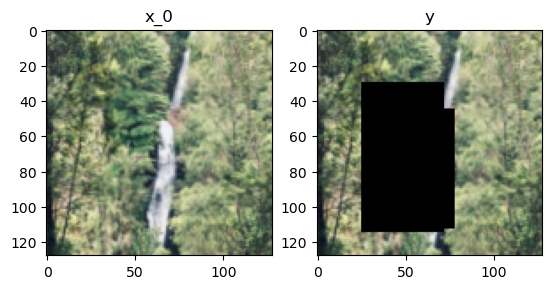

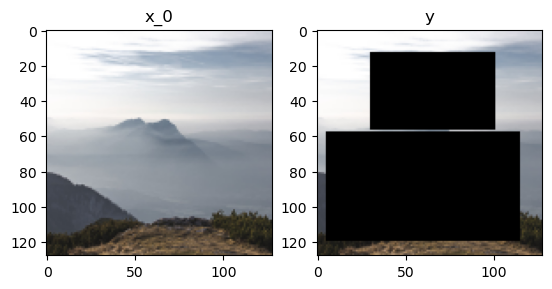

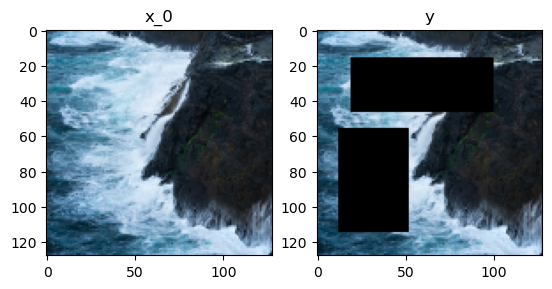

In [30]:
fpath = "/Users/gonzalo/Desktop/lhq_256/"
batch_size = 3
land_ds = ConditionalDataset_LHQ_Paint(fpath=fpath,img_size=128,frac =0.8,skip_first_n = 0,ext = ".png",
                                      transform=True, train = True)
land_loader = torch.utils.data.DataLoader(land_ds,batch_size=batch_size, shuffle=True)

for idx, (x_0, y) in enumerate(land_loader):
    for i in range(x_0.shape[0]):
        x_0_pil = land_ds.tensor2PIL(x_0[i])
        y_pil = land_ds.tensor2PIL(y[i])
        fig, ax = plt.subplots(1, 2)  
        ax[0].imshow(x_0_pil)  
        ax[0].set_title('x_0')  
        ax[1].imshow(y_pil)  
        ax[1].set_title('y') 
        plt.show()
    break

### Leaving some Border Pixels

In [31]:
class ConditionalDataset_LHQ_Paint(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string):   Path to the folder where images are stored
            img_size (int):   Size of output image img_size=height=width
            ext (string):     Type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            train (Bool):     Choose dataset to be either train set or test set. frac(float) required 
            frac (float):     value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
        """        
        self.img_size = img_size
        ### Create DataFrame
        file_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))

        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)] 
        
        
        if train: 
            df_train = self.df.sample(frac=frac,random_state=2)
            self.df = df_train
        else:
            df_train = self.df.sample(frac=frac,random_state=2)
            df_test = df.drop(df_train.index)
            self.df = df_test

        if transform: 
            intermediate_size = 150
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*img_size))
            
            transform_rotate =  transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize(intermediate_size,antialias=True),
                                                    transforms.RandomRotation(theta/np.pi*180,interpolation=transforms.InterpolationMode.BILINEAR),
                                                    transforms.CenterCrop(img_size),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
            
            transform_randomcrop  =  transforms.Compose([transforms.ToTensor(),
                                                         transforms.Resize(intermediate_size),
                                                         transforms.RandomCrop(img_size),
                                                         transforms.RandomHorizontalFlip(p=0.5), 
                                                         transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            self.transform =  transforms.RandomChoice([transform_rotate,transform_randomcrop])                                                  
        else :
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])

 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        # get image
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        # apply transformation
        img_tensor = self.transform(img)
        masked_img = img_tensor.clone()
        # draw random rectangle with min. hight and width of 125
        min_height = 125
        min_width = 125
        max_x = img_tensor.shape[1] - min_height
        max_y = img_tensor.shape[2] - min_width
        x = np.random.randint(0, max_x)  
        y = np.random.randint(0, max_y)
        max_height = min(self.img_size, img_tensor.shape[1] - x)
        max_width  = min(self.img_size, img_tensor.shape[2] - y) 
        rect_height = torch.randint(min_height, max_height, (1,)).item()
        rect_width  = torch.randint(min_width, max_width, (1,)).item() 
        masked_img[:, x:x+rect_height, y:y+rect_width] = -1 
        return img_tensor, masked_img
        
    def tensor2PIL(self,img):
        back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
        return back2pil(img)

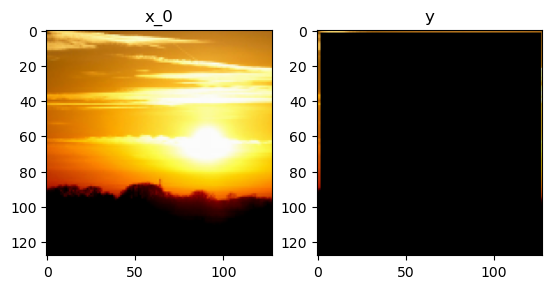

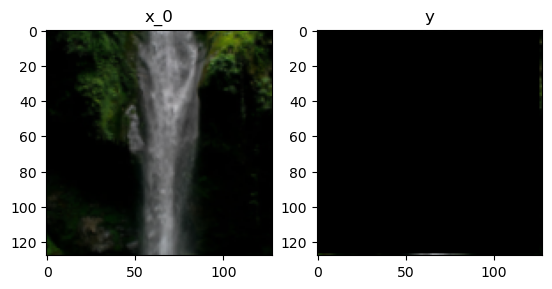

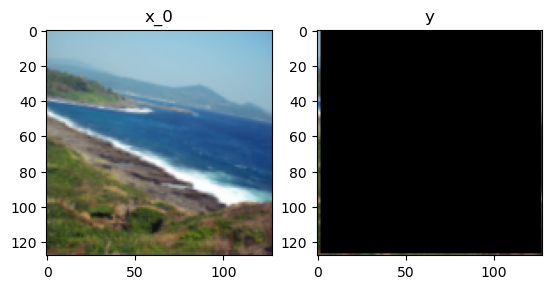

In [36]:
fpath = "/Users/gonzalo/Desktop/lhq_256/"
batch_size = 3
land_ds = ConditionalDataset_LHQ_Paint(fpath=fpath,img_size=128,frac =0.8,skip_first_n = 0,ext = ".png",
                                      transform=True, train = True)
land_loader = torch.utils.data.DataLoader(land_ds,batch_size=batch_size, shuffle=True)

for idx, (x_0, y) in enumerate(land_loader):
    for i in range(x_0.shape[0]):
        x_0_pil = land_ds.tensor2PIL(x_0[i])
        y_pil = land_ds.tensor2PIL(y[i])
        fig, ax = plt.subplots(1, 2)  
        ax[0].imshow(x_0_pil)  
        ax[0].set_title('x_0')  
        ax[1].imshow(y_pil)  
        ax[1].set_title('y') 
        plt.show()
    break

### Pepper Noise

In [37]:
class ConditionalDataset_LHQ_Paint(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string):   Path to the folder where images are stored
            img_size (int):   Size of output image img_size=height=width
            ext (string):     Type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            train (Bool):     Choose dataset to be either train set or test set. frac(float) required 
            frac (float):     value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
        """        
        self.img_size = img_size
        ### Create DataFrame
        file_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))

        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)] 
        
        
        if train: 
            df_train = self.df.sample(frac=frac,random_state=2)
            self.df = df_train
        else:
            df_train = self.df.sample(frac=frac,random_state=2)
            df_test = df.drop(df_train.index)
            self.df = df_test

        if transform: 
            intermediate_size = 150
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*img_size))
            
            transform_rotate =  transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize(intermediate_size,antialias=True),
                                                    transforms.RandomRotation(theta/np.pi*180,interpolation=transforms.InterpolationMode.BILINEAR),
                                                    transforms.CenterCrop(img_size),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
            
            transform_randomcrop  =  transforms.Compose([transforms.ToTensor(),
                                                         transforms.Resize(intermediate_size),
                                                         transforms.RandomCrop(img_size),
                                                         transforms.RandomHorizontalFlip(p=0.5), 
                                                         transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            self.transform =  transforms.RandomChoice([transform_rotate,transform_randomcrop])                                                  
        else :
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])

 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        # get image
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        # apply transformation
        img_tensor = self.transform(img)
        masked_img = img_tensor.clone()
        _, height, width = masked_img.shape
        x_coords = torch.randint(0, width, (900,))
        y_coords = torch.randint(0, height, (900,))
        for x, y in zip(x_coords, y_coords):
            masked_img[:, y, x] = -1
        return img_tensor, masked_img
        
    def tensor2PIL(self,img):
        back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
        return back2pil(img)

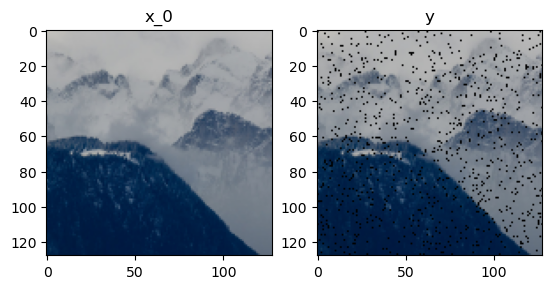

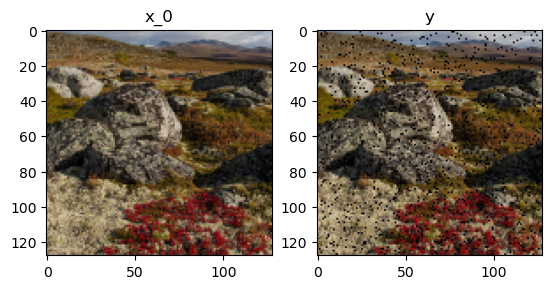

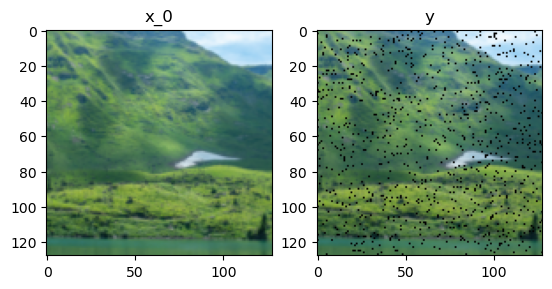

In [38]:
fpath = "/Users/gonzalo/Desktop/lhq_256/"
batch_size = 3
land_ds = ConditionalDataset_LHQ_Paint(fpath=fpath,img_size=128,frac =0.8,skip_first_n = 0,ext = ".png",
                                      transform=True, train = True)
land_loader = torch.utils.data.DataLoader(land_ds,batch_size=batch_size, shuffle=True)

for idx, (x_0, y) in enumerate(land_loader):
    for i in range(x_0.shape[0]):
        x_0_pil = land_ds.tensor2PIL(x_0[i])
        y_pil = land_ds.tensor2PIL(y[i])
        fig, ax = plt.subplots(1, 2)  
        ax[0].imshow(x_0_pil)  
        ax[0].set_title('x_0')  
        ax[1].imshow(y_pil)  
        ax[1].set_title('y') 
        plt.show()
    break